<a href="https://colab.research.google.com/github/amamra-abdenour/Deep_Learning_Python/blob/master/DeapLearning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top= False,
                  input_shape=(150,150,3)
)
conv_base.summary()

Using TensorFlow backend.






58892288/58889256 [==============================] - 2s 0us/step


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
________________________________________________________

In [6]:
import os
from google.colab import files

!pip install -q kaggle
uploaded = files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
print(os.listdir('/root/.kaggle/'))
!kaggle competitions download -c dogs-vs-cats -p /content/

import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
['kaggle.json']
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 35.1MB/s]
 95% 257M/271M [00:06<00:00, 43.9MB/s]
100% 271M/271M [00:06<00:00, 45.6MB/s]
 99% 537M/543M [00:10<00:00, 55.5MB/s]
100% 543M/543M [00:10<00:00, 55.5MB/s]
25000


NameError: ignored

In [10]:
import os
import shutil
try:
  shutil.rmtree('/content/cats_and_dogs_small/')
except IOError:
  print('file does not exist')
dataset_dir = '/content/train/'
base_dir ='/content/cats_and_dogs_small/'
os.mkdir(base_dir)

file does not exist


In [0]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
validation_dir_cats = os.path.join(validation_dir, 'cats')
os.mkdir(validation_dir_cats)

validation_dir_dogs = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dir_dogs)

In [0]:
test_dir_cats = os.path.join(test_dir, 'cats')
os.mkdir(test_dir_cats)

test_dir_dogs = os.path.join(test_dir, 'dogs')
os.mkdir(test_dir_dogs)


In [0]:
train_dir_cats = os.path.join(train_dir, 'cats')
os.mkdir(train_dir_cats)

train_dir_dogs = os.path.join(train_dir, 'dogs')
os.mkdir(train_dir_dogs)


In [15]:
#from train folder
print(dataset_dir)
frames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(train_dir_cats,frame)
  shutil.copyfile(src,dst)

/content/train/


In [0]:
frames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(validation_dir_cats,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(test_dir_cats,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(train_dir_dogs,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(validation_dir_dogs,frame)
  shutil.copyfile(src,dst)

In [0]:
frames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for frame in frames:
  src = os.path.join(dataset_dir, frame)
  dst = os.path.join(test_dir_dogs,frame)
  shutil.copyfile(src,dst)

In [21]:
print(train_dir_cats)
print(train_dir_dogs)
print(validation_dir_cats)
print(validation_dir_dogs)
print(test_dir_cats)
print(test_dir_dogs)

/content/cats_and_dogs_small/train/cats
/content/cats_and_dogs_small/train/dogs
/content/cats_and_dogs_small/validation/cats
/content/cats_and_dogs_small/validation/dogs
/content/cats_and_dogs_small/test/cats
/content/cats_and_dogs_small/test/dogs


In [23]:
from os import listdir
#sanity check
print(len(listdir(train_dir_cats)))
print(len(listdir(train_dir_dogs)))
print(len(listdir(validation_dir_cats)))
print(len(listdir(validation_dir_dogs)))
print(len(listdir(test_dir_cats)))
print(len(listdir(test_dir_dogs)))

1000
1000
500
500
500
500


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count,4, 4, 512))
    labels = np.zeros(shape =  (sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for input_batch, label_batch in generator:
      features_batch = conv_base.predict(input_batch)
      #print(i * batch_size , (i+1) * batch_size )
      features[i * batch_size : (i + 1) * batch_size] = features_batch
      labels[i * batch_size : (i + 1) * batch_size] = label_batch
      i += 1
      if i * batch_size >= sample_count:
        break
    return features, labels


In [25]:
train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
print(train_features.shape)
print(train_labels.shape)
print(validation_features.shape)
print(validation_labels.shape)

(2000, 4, 4, 512)
(2000,)
(1000, 4, 4, 512)
(1000,)


In [0]:
train_features = np.reshape(train_features,(2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features,(1000, 4 * 4 * 512))

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers import rmsprop
from keras.activations import relu, sigmoid

model = Sequential()
model.add(Dense(256, activation = relu, input_dim =(4*4*512)))
model.add(Dropout(0.5))
model.add(Dense(1,activation = sigmoid))

model.compile (optimizer = rmsprop(lr=2e-5),
               loss=binary_crossentropy,
               metrics=['acc'])

history = model.fit(train_features, train_labels, 
          epochs = 30, 
          batch_size = 20, 
          validation_data = (validation_features, validation_labels)
          )
model.save('VGG16_convbase_cats_dogs_1.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 926us/step - loss: 0.6236 - acc: 0.6490 - val_loss: 0.4540 - val_acc: 0.8300
Epoch 2/30
2000/2000 [==============================] - 1s 418us/step - loss: 0.4356 - acc: 0.8120 - val_loss: 0.3606 - val_acc: 0.8780
Epoch 3/30
2000/2000 [==============================] - 1s 401us/step - loss: 0.3706 - acc: 0.8420 - val_loss: 0.3233 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 1s 427us/step - loss: 0.3238 - acc: 0.8630 - val_loss: 0.2958 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 1s 416us/step - loss: 0.2873 - acc: 0.8860 - val_loss: 0.2874 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 1s 397

Text(0.5, 1.0, 'Training vs validation accuracy')

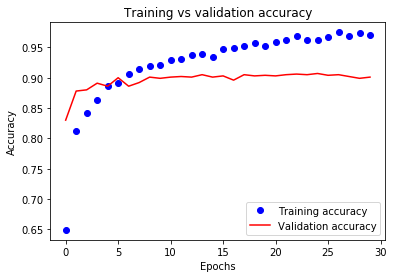

In [29]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(val_acc))
plt.plot(epochs,train_acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'r-',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')

Text(0.5, 1.0, 'Training vs validation loss')

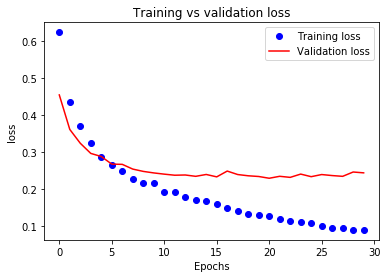

In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_loss))
plt.plot(epochs,train_loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'r-',label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training vs validation loss')

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [31]:
from keras.models import Sequential
from keras import layers
from keras import activations

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [32]:
#freezing the conv_base weights
print(len(model.trainable_weights))
conv_base.trainable = False
print(len(model.trainable_weights))
model.summary()

30
4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        #shuffle=True,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 14s - loss: 0.5894 - acc: 0.7050 - val_loss: 0.4670 - val_acc: 0.8060
Epoch 2/30
 - 13s - loss: 0.5263 - acc: 0.7540 - val_loss: 0.4031 - val_acc: 0.8300
Epoch 3/30
 - 13s - loss: 0.4759 - acc: 0.7900 - val_loss: 0.3648 - val_acc: 0.8580
Epoch 4/30
 - 12s - loss: 0.4434 - acc: 0.7900 - val_loss: 0.3435 - val_acc: 0.8680
Epoch 5/30
 - 12s - loss: 0.4467 - acc: 0.7810 - val_loss: 0.3612 - val_acc: 0.8520
Epoch 6/30
 - 13s - loss: 0.3925 - acc: 0.8350 - val_loss: 0.2711 - val_acc: 0.8860
Epoch 7/30
 - 13s - loss: 0.3949 - acc: 0.8190 - val_loss: 0.2833 - val_acc: 0.8640
Epoch 8/30
 - 12s - loss: 0.3706 - acc: 0.8370 - val_loss: 0.3185 - val_acc: 0.8700
Epoch 9/30
 - 12s - loss: 0.3508 - acc: 0.8460 - val_loss: 0.2815 - val_acc: 0.8860
Epoch 10/30
 - 13s - loss: 0.3691 - acc: 0.8430 - val_loss: 0.2871 - val_acc: 0.8720
Epoch 11/30
 - 13s - loss: 0.3712 - acc: 0.8360 - val_loss: 0.2705 - val_ac

Text(0.5, 1.0, 'Training vs validation accuracy')

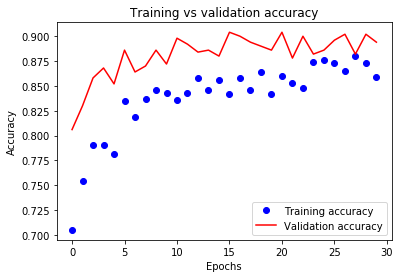

In [34]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(val_acc))
plt.plot(epochs,train_acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'r-',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')



Text(0.5, 1.0, 'Training vs validation loss')

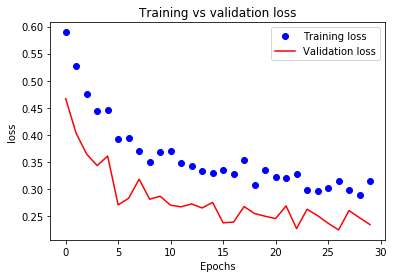

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_loss))
plt.plot(epochs,train_loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'r-',label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training vs validation loss')

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 15s - loss: 0.3034 - acc: 0.8650 - val_loss: 0.2257 - val_acc: 0.9060
Epoch 2/30
 - 13s - loss: 0.3161 - acc: 0.8590 - val_loss: 0.2467 - val_acc: 0.9040
Epoch 3/30
 - 13s - loss: 0.2630 - acc: 0.8910 - val_loss: 0.2027 - val_acc: 0.9040
Epoch 4/30
 - 13s - loss: 0.2672 - acc: 0.8920 - val_loss: 0.2100 - val_acc: 0.9260
Epoch 5/30
 - 13s - loss: 0.2278 - acc: 0.8990 - val_loss: 0.1907 - val_acc: 0.9180
Epoch 6/30
 - 14s - loss: 0.2375 - acc: 0.9030 - val_loss: 0.2309 - val_acc: 0.9220
Epoch 7/30
 - 14s - loss: 0.1972 - acc: 0.9200 - val_loss: 0.2007 - val_acc: 0.9240
Epoch 8/30
 - 13s - loss: 0.2342 - acc: 0.9110 - val_loss: 0.1804 - val_acc: 0.9260
Epoch 9/30
 - 14s - loss: 0.1558 - acc: 0.9410 - val_loss: 0.2016 - val_acc: 0.9280
Epoch 10/30
 - 13s - loss: 0.2276 - acc: 0.9090 - val_loss: 0.1948 - val_acc: 0.9180
Epoch 11/30
 - 13s - loss: 0.1913 - acc: 0.9190 - val_loss: 0.1827 - val_acc: 0.9260
Epoch 12/30
 - 13s - loss: 0.1663 - acc: 0.9260 - val_loss: 0.2025 - val_a

Text(0.5, 1.0, 'Training vs validation accuracy')

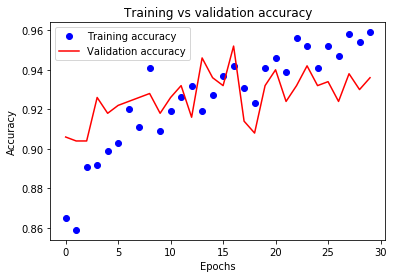

In [38]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(len(val_acc))
plt.plot(epochs,train_acc,'bo',label="Training accuracy")
plt.plot(epochs,val_acc,'r-',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs validation accuracy')

Text(0.5, 1.0, 'Training vs validation loss')

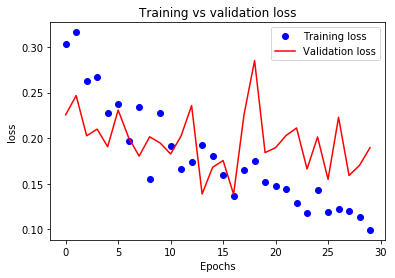

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_loss))
plt.plot(epochs,train_loss,'bo',label="Training loss")
plt.plot(epochs,val_loss,'r-',label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training vs validation loss')

In [0]:
def smooth_points(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points :
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [0]:
val_loss = smooth_points(val_loss)
train_loss = smooth_points(train_loss)

val_acc = smooth_points(val_acc)
train_acc = smooth_points(train_acc)

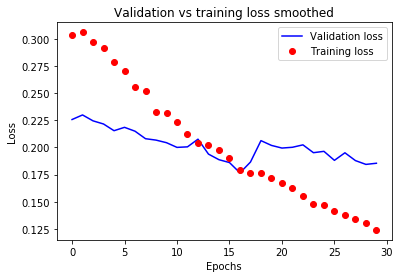

In [42]:
plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.plot(epochs, train_loss, 'ro', label = 'Training loss')
plt.title('Validation vs training loss smoothed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

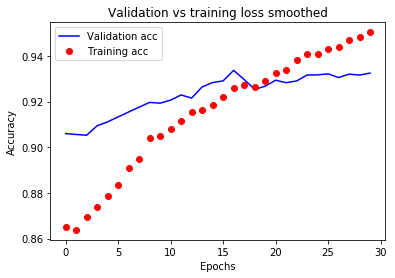

In [43]:
plt.plot(epochs, val_acc, 'b-', label = 'Validation acc')
plt.plot(epochs, train_acc, 'ro', label = 'Training acc')
plt.title('Validation vs training loss smoothed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [44]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode ='binary'
)
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps = 50)
print(test_accuracy, test_loss)

Found 1000 images belonging to 2 classes.
0.9299999928474426 0.20902007593307645


In [0]:
model.save('VGG16_convbase_cats_vs_dogs_final.h5')

In [0]:


try:
  shutil.copytree(base_dir,drive_base_dir)
except IOError as e:
  print('Copy error occured ', e)


In [54]:
print(listdir(drive_base_dir))

['test', 'train', 'validation']
